## Simulation of  modified Stuart-Landau (MSL) model with (generalized) phase model

### Setup

In [1]:
using GeneralizedPhaseReduction
using DifferentialEquations, PyPlot
using PyCall
using ProgressMeter
axes_grid1 = pyimport("mpl_toolkits.axes_grid1")

PyObject <module 'mpl_toolkits.axes_grid1' from 'C:\\Users\\yamta\\miniconda3\\lib\\site-packages\\mpl_toolkits\\axes_grid1\\__init__.py'>

### Model definition

In [2]:
dxdt(X, I, λ=5.0) = λ*(X[1]-I) - exp(I)*X[2]-λ*((X[1]-I)^2+X[2]^2)*(X[1]-I)
dydt(X, I, λ=5.0) = exp(I)*(X[1]-I) + λ*X[2]-λ*((X[1]-I)^2+X[2]^2)*X[2]
F(X, I) = [dxdt(X, I), dydt(X, I)]

D, N = 2, 2 # number of dimensions, units
Nθ = 1000
G(X, K) = K * ((1 .- eye(N)) * X[:, 1])
dt = 1e-3; T = 15.0; Nt = round(Int, T/dt)
trange = range(0, T, length=Nt)
alg = Tsit5(); #Rosenbrock23() #Tsit5();

In [3]:
@time Ts, ω, Xs = find_stable_periodic_solution(F, 0, D, Nθ, [1, 0], dt, Tsit5(), 2, 0.0, print_progress=false)
println("Ts=", Ts, " (sec) , ω=", ω, " (Hz)")

  8.742296 seconds (26.72 M allocations: 1.864 GiB, 5.19% gc time, 96.20% compilation time)
Ts=6.284 (sec) , ω=0.9998703544206853 (Hz)


In [4]:
# F, Imin, Imax, dI, D, Nθ, nothing, dt, alg, origin_val_idx, origin_thr
ωI, ζθI, ξθI, XsI = generalized_phase_sensitivity_func(F, -1.2, 1.2, 0.1, D, Nθ, nothing, dt, Tsit5(), 2, 0.0);

[1/3] Computing Xs(θ, I) and Z(θ, I)...100%|████████████| Time: 0:00:10


[2/3] Computing ζ(θ, I)...
[3/3] Computing ξ(θ, I)...


In [5]:
function coupled_func!(dX, X, p, t)
    g, κ = p
    Iext = g(X) # input
    for i in 1:size(dX)[1]
        dX[i, :] = κ[i] * F(X[i, :], Iext[i])
    end
end

coupled_func! (generic function with 1 method)

### Run simulation

In [6]:
K = 0.5
κ = [1.0, 1.5]
initθ = [π/2, π]
NΘ = 100
input_mode = "I" # "I" or "PQ"

"I"

In [7]:
g(X) = G(X, K)
IΘ = compute_IsΘ(g, N, D, XsI, NΘ);

Computing I₀(θ₁, θ₂)...100%|████████████████████████████| Time: 0:00:00


In [8]:
function all_simulation(N, D, T, ωI, ζθI, ξθI, XsI, coupled_func!, G, K, κ, initθ, alg, NΘ=50, input_mode="I")
    @assert (input_mode == "I" || input_mode == "PQ") "input_mode must be `I` or `PQ`."
    
    g(X) = G(X, K)
    Tos, Xos, Θgos, Θcos = coupled_original_system(N, D, T, XsI, g, coupled_func!, initθ, κ, alg);
    Tcpm, Xcpm, Θcpm = coupled_conventinal_phase_model(N, D, T, XsI, g, ωI, ζθI, Θcos[1, :], κ, alg)
    if input_mode == "I"
        IΘ = compute_IsΘ(g, N, D, XsI, NΘ)
        Tgpm, Xgpm, Θgpm = coupled_generalized_phase_model_I(N, D, T, XsI, IΘ, ωI, ξθI, Θgos[1, :], κ, alg);
        return Tos, Tcpm, Tgpm, Xos, Xcpm, Xgpm, Θgos, Θcos, Θcpm, Θgpm, IΘ
    elseif input_mode == "PQ"
        QΘ = compute_QΘ(g, N, D, XsI, κ, ωI, NΘ)
        Xgpm, Θgpm = coupled_generalized_phase_model_PQ(N, D, T, XsI, QΘ, ωI, ζθI, ξθI, Θgos[1, :], κ, g, alg)
        return Xos, Xcpm, Xgpm, Θgos, Θcos, Θcpm, Θgpm, QΘ
    end
end

all_simulation (generic function with 3 methods)

In [9]:
@time Tos, Tcpm, Tgpm, Xos, Xcpm, Xgpm, Θgos, Θcos, Θcpm, Θgpm, IΘ = all_simulation(
    N, D, T, ωI, ζθI, ξθI, XsI, coupled_func!, G, K, κ, initθ, alg, NΘ, input_mode);

Computing I₀(θ₁, θ₂)...100%|████████████████████████████| Time: 0:00:00


 23.162448 seconds (64.83 M allocations: 3.694 GiB, 3.82% gc time, 97.68% compilation time)


### Results

In [13]:
plt.rc("text", usetex=true)
PyCall.PyDict(plt."rcParams")["font.size"] = 14
PyCall.PyDict(plt."rcParams")["xtick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["ytick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["xtick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["ytick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["xtick.top"] = true 
PyCall.PyDict(plt."rcParams")["ytick.right"] = true 
PyCall.PyDict(plt."rcParams")["font.family"] = "Arial"
PyCall.PyDict(plt."rcParams")["text.latex.preamble"] = [raw"\usepackage{amsmath}"];

In [10]:
ωt1os, ωt1cpm, ωt1gpm = (κ[1] * ω) .* Tos, (κ[1] * ω) .* Tcpm, (κ[1] * ω) .* Tgpm;
ωt2os, ωt2cpm, ωt2gpm = (κ[2] * ω) .* Tos, (κ[2] * ω) .* Tcpm, (κ[2] * ω) .* Tgpm;
Δωtos, Δωtcpm, Δωtgpm,  = ωt2os - ωt1os, ωt2cpm - ωt1cpm, ωt2gpm - ωt1gpm;

In [11]:
Θrange = range(0, 2π, length=100)
Irange = 1.2:-0.1:-1.2;

In [12]:
cm = get_cmap(:tab20)

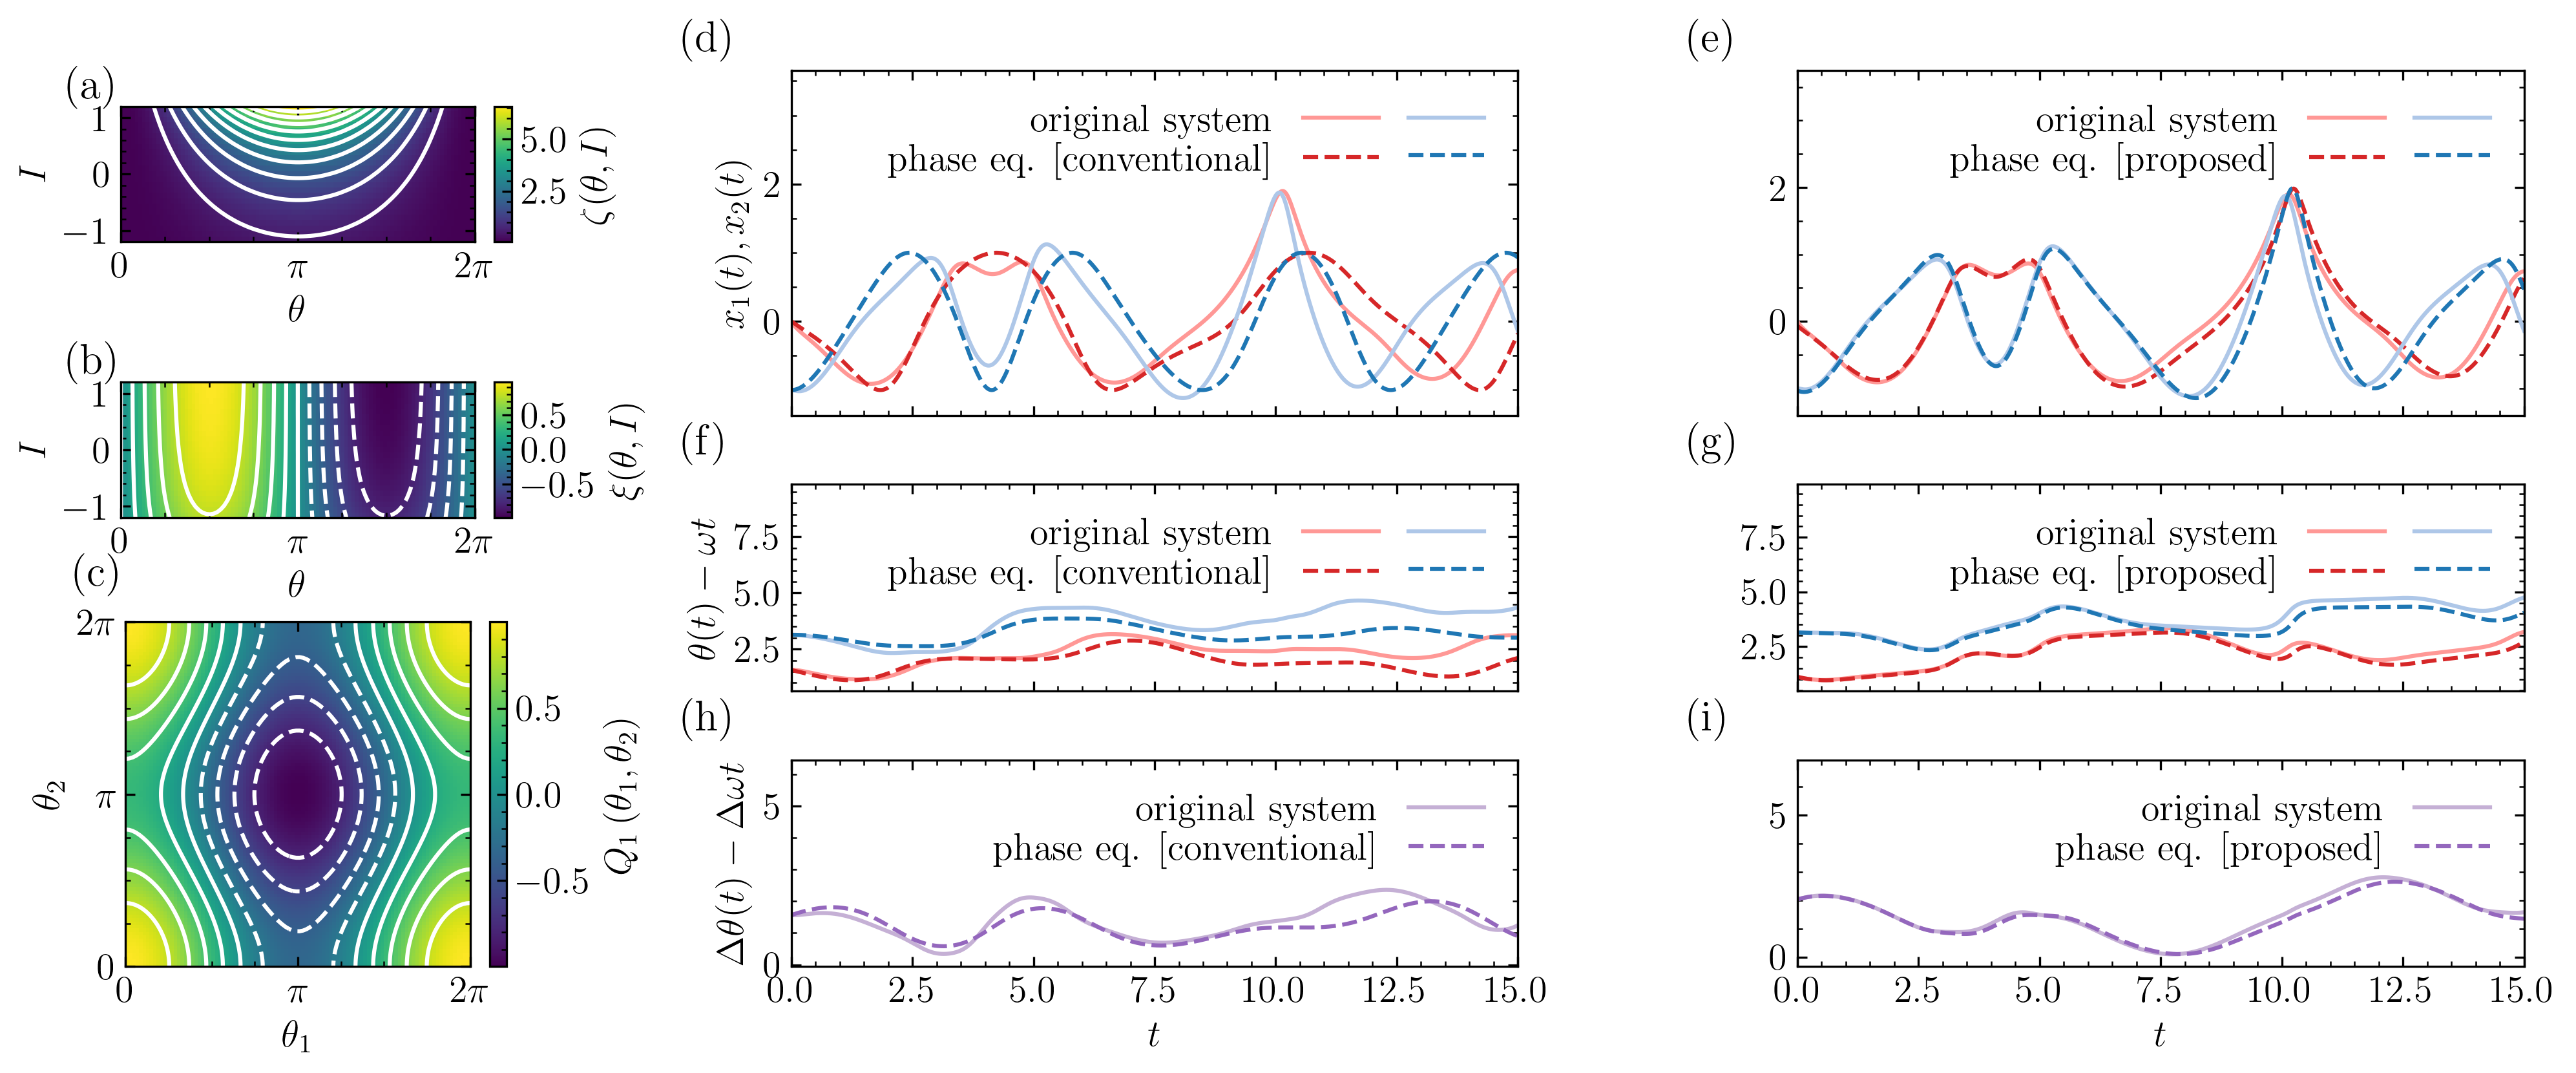

In [16]:
figure(figsize=(16, 6), dpi=300)
gca().set_rasterization_zorder(1)
#### left ####
ax7 = subplot2grid((7, 8), (0, 0), rowspan=2, colspan=2)
ζ=ζθI(Θrange, Irange)'
contour(Θrange, Irange, ζ, 10, colors="white")
imshow(ζ, extent=(0, 2pi, -1.2, 1.2))
ylabel(L"$I$"); xlabel(L"$\theta$");
xticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
divider7 = axes_grid1.make_axes_locatable(ax7)
cax7 = divider7.append_axes("right", size="5%", pad=0.1)
cbar7 = colorbar(cax=cax7)
cbar7.set_label(L"$\zeta (\theta, I)$")
ax7.text(-0.15, 1.3, "(a)", fontsize=16, transform=ax7.transAxes, fontweight="bold", va="top")

ax8 = subplot2grid((7, 8), (2, 0), rowspan=2, colspan=2)
ξ=ξθI(Θrange, Irange)'
contour(Θrange, Irange, ξ, 10, colors="white")
imshow(ξ, extent=(0, 2pi, -1.2, 1.2))
ylabel(L"$I$"); xlabel(L"$\theta$");
xticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
divider8 = axes_grid1.make_axes_locatable(ax8)
cax8 = divider8.append_axes("right", size="5%", pad=0.1)
cbar8 = colorbar(cax=cax8)
cbar8.set_label(L"$\xi (\theta, I)$")
ax8.text(-0.15, 1.3, "(b)", fontsize=16, transform=ax8.transAxes, fontweight="bold", va="top")

ax9 = subplot2grid((7, 8), (4, 0), rowspan=3, colspan=2)
IΘmap=IΘ[1](Θrange, Θrange)
contour(Θrange, Θrange, IΘmap, 10, colors="white")
imshow(reverse(IΘmap, dims=1), extent=(0, 2pi, 0, 2pi))
xlabel(L"$\theta_1$"); ylabel(L"$\theta_2$");
xticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
yticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
divider9 = axes_grid1.make_axes_locatable(ax9)
cax9 = divider9.append_axes("right", size="5%", pad=0.1)
cbar9 = colorbar(cax=cax9)
cbar9.set_label(L"$Q_1\left(\theta_1, \theta_2\right)$")
ax9.text(-0.15, 1.2, "(c)", fontsize=16, transform=ax9.transAxes, fontweight="bold", va="top")

#### middle ####
ax1 = subplot2grid((7, 8), (0, 2), rowspan=3, colspan=3)
# title("Conventinal phase model")
plot(Tos, Xos[:, 1, 1], label="original system", color=cm(7))
plot(Tcpm, Xcpm[:, 1, 1], "--", label="phase eq. [conventional]", color=cm(6))
plot(Tos, Xos[:, 2, 1], label=" ", color=cm(1))
plot(Tcpm, Xcpm[:, 2, 1], "--", label=" ", color=cm(0))
xlim(0, T); ylim(ylim()[1]-0.1, ylim()[2]+1.6); ylabel(L"$x_1(t), x_2(t)$"); 
plt.gca().axes.xaxis.set_ticklabels([])
ax1.text(-0.15, 1.15, "(d)", fontsize=16, transform=ax1.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax3=subplot2grid((7, 8), (3, 2), rowspan=2, colspan=3)
plot(Tos, Θcos[:, 1]-ωt1os, label="original system", color=cm(7))
plot(Tcpm, Θcpm[:, 1]-ωt1cpm, "--", label="phase eq. [conventional]", color=cm(6))
plot(Tos, Θcos[:, 2]-ωt2os, label=" ", color=cm(1)) 
plot(Tcpm, Θcpm[:, 2]-ωt2cpm, "--", label=" ", color=cm(0))
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+5); ylabel(L"$\theta(t)-\omega t$"); 
plt.gca().axes.xaxis.set_ticklabels([])
ax3.text(-0.15, 1.3, "(f)", fontsize=16, transform=ax3.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax5=subplot2grid((7, 8), (5, 2), rowspan=2, colspan=3)
plot(Tos, Θcos[:, 2]-Θcos[:, 1]-Δωtos, label="original system", color=cm(9))
plot(Tcpm, Θcpm[:, 2]-Θcpm[:, 1]-Δωtcpm, "--", label="phase eq. [conventional]", color=cm(8))
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+4); ylabel(L"$\Delta \theta(t)-\Delta \omega t$"); xlabel(L"$t$");
ax5.text(-0.15, 1.3, "(h)", fontsize=16, transform=ax5.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=1, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

#### right ####
ax2=subplot2grid((7, 8), (0, 5), rowspan=3, colspan=3)
plot(Tos, Xos[:, 1, 1], label="original system", color=cm(7))
plot(Tgpm, Xgpm[:, 1, 1], "--", label="phase eq. [proposed]", color=cm(6))
plot(Tos, Xos[:, 2, 1], label=" ", color=cm(1))
plot(Tgpm, Xgpm[:, 2, 1], "--", label=" ", color=cm(0))
xlim(0, T); ylim(ylim()[1]-0.1, ylim()[2]+1.6);  
plt.gca().axes.xaxis.set_ticklabels([])
ax2.text(-0.15, 1.15, "(e)", fontsize=16, transform=ax2.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax4=subplot2grid((7, 8), (3, 5), rowspan=2, colspan=3)
plot(Tos, Θgos[:, 1]-ωt1os, label="original system", color=cm(7))
plot(Tgpm, Θgpm[:, 1]-ωt1gpm, "--", label="phase eq. [proposed]", color=cm(6))
plot(Tos, Θgos[:, 2]-ωt2os, label=" ", color=cm(1)) 
plot(Tgpm, Θgpm[:, 2]-ωt2gpm, "--", label=" ", color=cm(0))
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+5); 
plt.gca().axes.xaxis.set_ticklabels([])
ax4.text(-0.15, 1.3, "(g)", fontsize=16, transform=ax4.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax6=subplot2grid((7, 8), (5, 5), rowspan=2, colspan=3)
plot(Tos, Θgos[:, 2]-Θgos[:, 1]-Δωtos, label="original system", color=cm(9))
plot(Tgpm, Θgpm[:, 2]-Θgpm[:, 1]-Δωtgpm, "--", label="phase eq. [proposed]", color=cm(8))
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+4); 
xlabel(L"$t$");
ax6.text(-0.15, 1.3, "(i)", fontsize=16, transform=ax6.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=1, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

subplots_adjust(hspace=1, wspace=5)
#show()
savefig("fig1.svg")

## Fourier average

In [17]:
function update!(dX, X, p, t)
    dX[:] = F(X, p)
end

update! (generic function with 1 method)

- `initX`:位相を求めたい状態 
- `input_param`: 入力（I）など
- `T₀`: `input_param`に対応するlimit cycleの周期
- `num_total`:シミュレーション時間は`num_total*T₀`
- `num_relax`: 緩和時間は`num_relax*T₀`
- `dt`: time step. 今のところ固定だが，adaptiveにすれば実行時間は短くなるはず．

In [18]:
function truncated_fourier_averages(initX, input_param, T₀, num_total=4, num_relax=2, dt=1e-3)
    numT₀ = round(Int, T₀/dt)
    NT = round(Int, num_total*numT₀) # total time
    NREL = round(Int, num_relax*numT₀) # relax
    time = range(0, num_total*T₀, length=NT)
    ω₀ = 2pi / T₀
    D = size(initX)[1]
    
    integrator = get_ode_integrator(update!, initX, dt, input_param, Tsit5())
    Xrec = zeros(D, NT) # recording array
    
    for tt in 1:NT
        Xrec[:, tt] = integrator.u
        step!(integrator, dt, true)
    end
    
    #figure(figsize=(3,3))
    #plot(Xrec[1, :], Xrec[2, :])
    #tight_layout()
    
    # cis(x) = exp(ix) 
    f = sum(Xrec[1, NREL:NT] .* cis.(-ω₀*time[NREL:NT]) * dt) / (num_total-num_relax)*T₀
    phase = angle.(f)
    return f, phase
end

truncated_fourier_averages (generic function with 4 methods)

In [19]:
function conventional_tfa(X, N, Ts, num_total, num_relax, dt)
    Θfa = zeros(size(X)[1:2])
    @showprogress for i in 1:size(X)[1]
        for j in 1:N
            _, θ = truncated_fourier_averages(X[i, j, :], 0, Ts, num_total, num_relax, dt)
            Θfa[i, j] = θ
        end
    end
    Θfa = phase2cum_phase(Θfa, N);
    return Θfa
end

conventional_tfa (generic function with 1 method)

In [20]:
Θcfa = conventional_tfa(Xos, N, Ts, 2, 1, dt);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:56


In [21]:
function generalized_tfa(X, N, g, ωI, num_total, num_relax, dt)
    Θfa = zeros(size(X)[1:2])
    @showprogress for i in 1:size(X)[1]
        Iex = g(X[i, :, :])
        TsI = 2pi ./ ωI.(Iex)
        for j in 1:N
            _, θ = truncated_fourier_averages(X[i, j, :], Iex[j], TsI[j], num_total, num_relax, dt)
            Θfa[i, j] = θ
        end
    end
    Θfa = phase2cum_phase(Θfa, N);
    return Θfa
end

generalized_tfa (generic function with 1 method)

In [22]:
Θgfa = generalized_tfa(Xos, N, g, ωI, 2, 1, dt);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:01


### Estimation from Truncated Fourier average

In [30]:
function phase2state_conventional(D, Θ, XsI)
    Nt, N = size(Θ)
    X = zeros(Nt, N, D);
    for tt in 1:Nt
        for i in 1:N
            X[tt, i, :] = [XsI[j](mod(Θ[tt, i], 2π), 0) for j in 1:D] # memory
        end
    end    
    return X
end

phase2state_conventional (generic function with 1 method)

In [33]:
function phase2state_generalized_I(D, Θ, XsI, IΘ)
    Nt, N = size(Θ)
    X = zeros(Nt, N, D);
    for tt in 1:Nt
        for i in 1:N
            X[tt, i, :] = [XsI[j](mod(Θ[tt, i], 2π), IΘ[i](mod.(Θ[tt, :], 2π)...)) for j in 1:D] # memory
        end
    end    
    return X
end

phase2state_generalized_I (generic function with 1 method)

In [32]:
Xcfa = phase2state_conventional(D, Θcfa, XsI);

In [35]:
Xgfa = phase2state_generalized_I(D, Θgfa, XsI, IΘ);

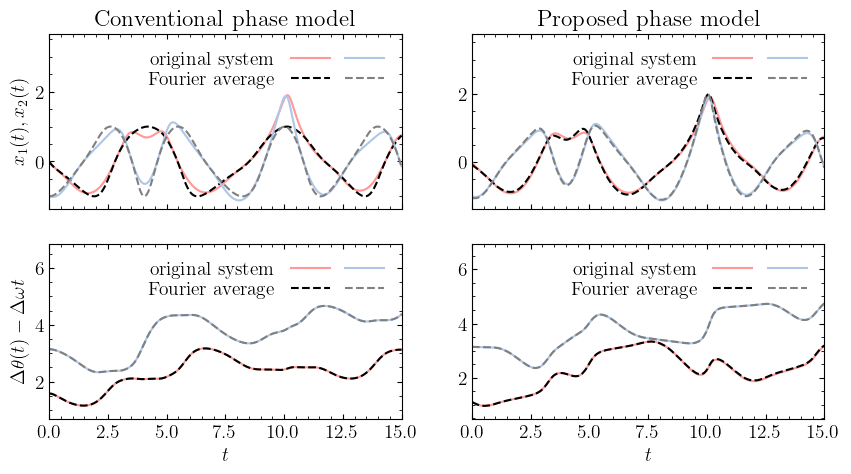

PyObject Text(0.5, 27.219312263257564, '$t$')

In [49]:
figure(figsize=(10, 5))
subplot(2,2,1)
title("Conventional phase model")
plot(Tos, Xos[:, 1, 1], label="original system", color=cm(7))
plot(Tos, Xcfa[:, 1, 1], "--", label="Fourier average", color="k")
plot(Tos, Xos[:, 2, 1], label=" ", color=cm(1))
plot(Tos, Xcfa[:, 2, 1], "--", label=" ", color="gray")
xlim(0, T); ylim(ylim()[1]-0.1, ylim()[2]+1.6); ylabel(L"$x_1(t), x_2(t)$"); 
plt.gca().axes.xaxis.set_ticklabels([])
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

subplot(2,2,2)
title("Proposed phase model")
plot(Tos, Xos[:, 1, 1], label="original system", color=cm(7))
plot(Tos, Xgfa[:, 1, 1], "--", label="Fourier average", color="k")
plot(Tos, Xos[:, 2, 1], label=" ", color=cm(1))
plot(Tos, Xgfa[:, 2, 1], "--", label=" ", color="gray")
xlim(0, T); ylim(ylim()[1]-0.1, ylim()[2]+1.6);  
plt.gca().axes.xaxis.set_ticklabels([])
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

subplot(2,2,3)
plot(Tos, Θcos[:, 1]-ωt1os, label="original system", color=cm(7))
plot(Tos, Θcfa[:, 1]-ωt1os, label="Fourier average", "--", color="k")
plot(Tos, Θcos[:, 2]-ωt2os, label=" ", color=cm(1)) 
plot(Tos, Θcfa[:, 2]-ωt2os, label=" ", "--", color="gray")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+2); ylabel(L"$\Delta \theta(t)-\Delta \omega t$"); xlabel(L"$t$");

subplot(2,2,4)
plot(Tos, Θgos[:, 1]-ωt1os, label="original system", color=cm(7))
plot(Tos, Θgfa[:, 1]-ωt1os, label="Fourier average", "--", color="k")
plot(Tos, Θgos[:, 2]-ωt2os, label=" ", color=cm(1)) 
plot(Tos, Θgfa[:, 2]-ωt2os, label=" ", "--", color="gray")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+2); xlabel(L"$t$")